In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
mpl_cols = ['#3388dd', '#aa3377', '#449911']

In [3]:
import os, sys, inspect
# realpath() will make your script run, even if you symlink it :)
cmd_folder = os.path.realpath(os.path.abspath(
        os.path.join(os.path.split(inspect.getfile( inspect.currentframe() ))[0],
                     '..', '..', 'labeled-experiments', 'nn-classifiers')))
print 'Added {0} to path.'.format(cmd_folder)
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

Added /Users/an/dev-repos/factory-robot-simulator/labeled-experiments/nn-classifiers to path.


In [4]:
import labeling_network as lbln
from matplotlib import pyplot as plt
import theano
import theano.tensor as T
import numpy as np
from labeling_network import FullyConnectedLayer, ConvPoolLayer

import time
import datetime

Running with a CPU.  If this is not desired, then the modify network3.py to set
the GPU flag to True.


In [5]:
rng = np.random.RandomState(12345678)

In [6]:
dataPath = '../../../factory-robot-data/imgs_2015-10-17/'

In [7]:
def load_action_data(filename, lower, upper):
    action_file = open(filename)
    lines = action_file.readlines()[lower:upper]
    action_file.close()
    data = np.asarray([int(l) for l in lines])
    return data
#     return data.reshape(upper - lower, n_direction_sensors * n_classes)


In [8]:
def convert_actions(actions, n_actions):
    result = []
    for a in actions:
        x = [0.0] * n_actions
        x[a] = 1.0
        result.append(x)
    return np.asarray(result, dtype=theano.config.floatX)
        

In [9]:
def construct_training_examples(label_data, action_data, delta_t, n_past, n_future):
    assert len(label_data) == len(action_data)
    percept_len = label_data.shape[1]
    n_actions = action_data.shape[1]
    
    xs_length = n_past*percept_len + (n_past + n_future - 1)*n_actions
    t_length = n_future*percept_len
    
    training_data_xs = np.empty((len(label_data) - (n_past + n_future - 1)*delta_t, xs_length), 
                                dtype=theano.config.floatX)
    training_data_ts = np.empty((len(label_data) - (n_past + n_future - 1)*delta_t, t_length),
                                dtype=theano.config.floatX)
    
    for i in xrange(n_past * delta_t, len(label_data) - ((n_future-1)*delta_t + 1)):
        example = []
        for j in xrange(n_future):
            training_data_ts[i - n_past*delta_t, j*percept_len: (j+1)*percept_len] = np.asarray(
                label_data[i+j], dtype=theano.config.floatX)
            
            if (n_future - j) > 1:
                xs_a = np.mean(action_data[i + j*delta_t: 
                                           i + (j+1)*delta_t] , axis=0)
#                 print -(n_future-j-1)*n_actions
#                 print -(n_future-j-2)*n_actions
#                 print xs_a.shape
#                 print
                if n_future - j == 2:
                    training_data_xs[i - n_past*delta_t, -(n_future-j-1)*n_actions:] = xs_a
                else:
                    training_data_xs[i - n_past*delta_t, -(n_future-j-1)*n_actions:
                                                         -(n_future-j-2)*n_actions] = xs_a
        for j in xrange(n_past):
            xs_d = label_data[i - (n_past*delta_t) + j*delta_t]
            xs_a = np.mean(action_data[i - (n_past*delta_t) + j*delta_t : 
                                       i - (n_past*delta_t) + (j+1)*delta_t] , axis=0)
            training_data_xs[i - n_past*delta_t, j*(percept_len + n_actions):
                                                 (j+1)*percept_len + j*n_actions] = xs_d
            training_data_xs[i - n_past*delta_t, (j+1)*percept_len + j*n_actions:
                                                 (j+1)*(percept_len + n_actions)] = xs_a
             
    return training_data_xs, training_data_ts

In [10]:
def shuffle_data(data, rng):
    xs, ts = data
    index_set = np.asarray(range(len(xs)))
    rng.shuffle(index_set)
    return xs[index_set], ts[index_set]

In [18]:
n_train = 10
n_valid = 5000
n_test = 1000

n_direction_sensors=7
n_classes=2
n_actions=3
delta_t = 2
n_past = 12
n_future = 5


lower = 0
upper = n_train + n_valid + n_test + delta_t*n_past



load_time_start = time.time()
label_data_raw = lbln.load_labeling_data(dataPath+'labels.dat', lower, upper, mask=-1, 
                                         n_direction_sensors=n_direction_sensors, 
                                         n_classes=n_classes)
actions_raw = convert_actions(load_action_data(dataPath+'actions.dat', lower, upper), 
                              n_actions=n_actions)

all_data = construct_training_examples(label_data_raw, actions_raw, delta_t, n_past, n_future)
all_data = shuffle_data(all_data, rng)

training_xs = theano.shared(all_data[0][:n_train], borrow=True)
training_ts = theano.shared(all_data[1][:n_train], borrow=True)

valid_xs = theano.shared(all_data[0][n_train: n_train+n_valid], borrow=True)
valid_ts = theano.shared(all_data[1][n_train: n_train+n_valid], borrow=True)

test_xs = theano.shared(all_data[0][n_train+n_valid:], borrow=True)
test_ts = theano.shared(all_data[1][n_train+n_valid:], borrow=True)


print 'Loading data took {0:.5} seconds'.format(time.time() - load_time_start)

Loading data took 1.0568 seconds


In [19]:
def visualize_frame(ax, percept, n_sensors, action, color=mpl_cols[0]):
    percept_length = len(percept)
    n_actions = len(action)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.bar(np.arange(percept_length), percept, 
           color=color,
           edgecolor='none',
           align='center')
    ax.bar(np.arange(percept_length, percept_length + n_actions), action,
          color=mpl_cols[1],
          edgecolor='none',
          align='center')
    ax.set_xlim(-0.5, percept_length+n_actions-0.5)
    ax.set_ylim(0, 1)
    ax.axvline(x=n_sensors-0.5)
    ax.axvline(x=percept_length-0.5)

def visualize_example(x, t, percept_length, n_sensors, n_actions, n_past, n_future):
    fig = plt.figure(figsize=(6, 1*(n_past+1)))
    for i in xrange(n_past):
        ax = fig.add_subplot(n_past + n_future, 1, i + 1)
        visualize_frame(ax, 
                        x[i*(percept_length + n_actions):
                             (i + 1)*percept_length + i*n_actions],
                        n_sensors,
                        x[(i+1)*percept_length + i*n_actions:
                          (i + 1)*(percept_length + n_actions)])
    for i in xrange(n_future-1):
        print x[n_past*(percept_length + n_actions) + i*n_actions:
                n_past*(percept_length + n_actions) + (i + 1)*n_actions]      
    
    for i in xrange(n_future):
        ax = fig.add_subplot(n_past + n_future, 1, n_past + i + 1)
        visualize_frame(ax, 
                        t[i*percept_length: (i+1)*percept_length], 
                        n_sensors, 
                        np.zeros(n_actions), 
                        color=mpl_cols[2])
    plt.show()

0


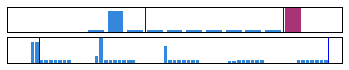

In [20]:
for i in xrange(0, 1):
    fig = plt.figure(figsize=(6, 1))
    ax = fig.add_subplot(211)
    ax2= fig.add_subplot(212)
    print i
    visualize_frame(ax, label_data_raw[i + delta_t*n_past], 7, actions_raw[i])
    visualize_frame(ax2, training_ts.get_value()[i], 7, np.zeros(3))
    plt.show()

[ 1.  0.  0.]
[ 1.  0.  0.]
[ 1.  0.  0.]
[ 1.  0.  0.]


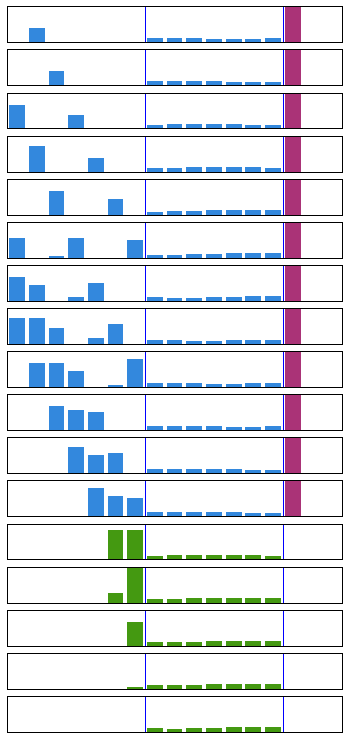

In [21]:
for i in xrange(0, 1, delta_t):
    visualize_example(training_xs.get_value()[i], training_ts.get_value()[i], 
                      n_direction_sensors*n_classes, 
                      n_direction_sensors, 
                      n_actions, 
                      n_past, 
                      n_future)

##### Training parameters

In [15]:
mini_batch_size = 10

### Train the Network. 

In [16]:
network = lbln.Network([
        FullyConnectedLayer(n_in=n_past*(n_direction_sensors*n_classes + n_actions) + (n_future-1)*n_actions, 
                            n_out=300),
        FullyConnectedLayer(n_in=300, 
                            n_out=n_direction_sensors*n_classes*n_future)
    ], mini_batch_size)

In [ ]:
network.SGD((training_xs, training_ts), 
            100, 
            mini_batch_size, 
            0.2, 
            (valid_xs, valid_ts), 
            (test_xs, test_ts),
            'trained-networks/t_nf' + str(n_future) + '_np' + str(n_past) + '_' + datetime.datetime.now().strftime('%Y%m%d%H%M%S'),
#             learning_curve_file_name='decoder_learning_curve_bigdata',
            rmsprop=(0.001, 0.9, 1e-6, 1.0)
           )

### Test network.

In [24]:
network_filename = 'trained-networks/t_nf5_np12_20151018055615'

n_eval = 7000

simple_errors = []
net_errors = []


net = network.load_from_file(network_filename, mini_batch_size)
for x, t in zip(valid_xs.get_value()[:n_eval], valid_ts.get_value()[:n_eval]):
#     simple_prediction = x[-(n_direction_sensors*n_classes + n_actions) : -n_actions]
    net_prediction = net.get_single_output(x)
#     simple_errors.append(np.mean((simple_prediction - t) ** 2))
    net_errors.append(np.mean((net_prediction - t) ** 2))
#     print prediction
#     print t
#     print (prediction - t) ** 2
#     print np.mean((prediction-t) ** 2)
# print 'mse simple: {0}'.format(np.mean(simple_errors))
print 'mse net:    {0}'.format(np.mean(net_errors))

Loading network: 2 layers loaded.
mse net:    0.00561058402274


[ 0.  0.  1.]
[ 0.  0.  1.]
[ 0.  0.  1.]
[ 0.  0.  1.]


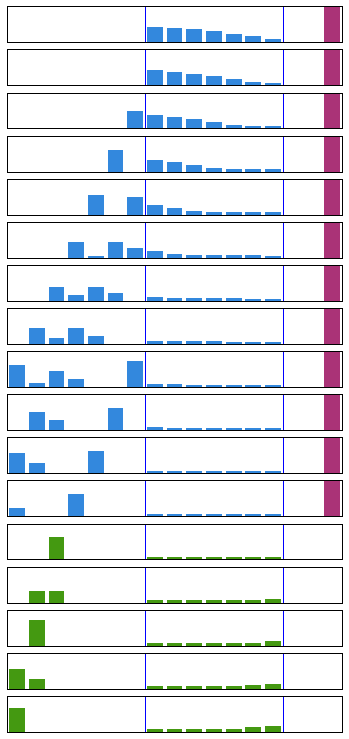

[ 0.  0.  1.]
[ 0.  0.  1.]
[ 0.  0.  1.]
[ 0.  0.  1.]


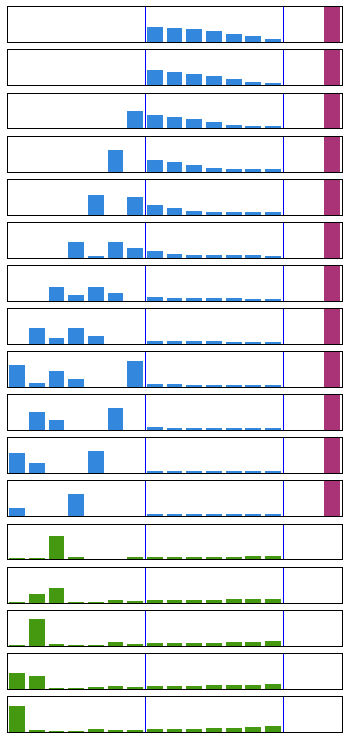

In [28]:
i = rng.randint(valid_xs.get_value().shape[0])
ex = valid_xs.get_value()[i]
visualize_example(ex, valid_ts.get_value()[i], 
                      n_direction_sensors*n_classes, 
                      n_direction_sensors, 
                      n_actions, 
                      n_past, 
                      n_future)

visualize_example(ex, net.get_single_output(ex), 
                      n_direction_sensors*n_classes, 
                      n_direction_sensors, 
                      n_actions, 
                      n_past, 
                      n_future)

In [ ]:
import pylab
pylab.rcParams['figure.figsize'] = (6.0, 6.0)

In [ ]:
test_data_xs = test_data[0].get_value()
test_data_ts = test_data[1].get_value()

valid_data_xs = valid_data[0].get_value()
valid_data_ts = valid_data[1].get_value()


### Determine all Losses on test images.

In [ ]:
def print_classification(index, n_classes=5, n_directions=5):
#     print 'Target:    ', classifications[index][1]
#     print 'Prediction:', classifications[index][2]
    print 'Loss:      ', classifications[index][3]
    plt.imshow(classifications[index][0].reshape(64, 64, 3), interpolation='nearest')
    plt.show()
    
    fig = plt.figure(figsize=(12,6))
    ax_left = fig.add_subplot(121)
    ax_right = fig.add_subplot(122)
    ax_left.set_ylim(0,1)
    ax_right.set_ylim(0,1)
    bar_width = 0.1
    chart_colors = ['#ff2222', '#3399bb', '#55aa22', '#bbee33', '#881144']
    for i in xrange(n_classes):
        ax_left.bar(np.arange(n_directions)-(n_directions/2) + (i - n_directions/2.0 + 0.5)*bar_width,
               classifications[index][1][i*n_directions: (i+1)*n_directions],
               bar_width,
               color=chart_colors[i],
               align='center')
        ax_right.bar(np.arange(n_directions)-(n_directions/2) + (i - n_directions/2.0 + 0.5)*bar_width,
               classifications[index][2][i*n_directions: (i+1)*n_directions],
               bar_width,
               color=chart_colors[i],
               align='center')
    plt.show()
    print '---------'
        


# Determine all errors on the test images
classifications = []
for x, t in zip(valid_data_xs, valid_data_ts):
    prediction = network.get_single_output(x)
    error = np.mean((t - prediction) ** 2)
    classifications.append((x, t, prediction, error))

print '--- Worst predictions: ---'
classifications = sorted(classifications, key = lambda (x, t, p, e): e, reverse=True)
print_classification(0)
print_classification(1)

print '\n\n'
print '--- Median prediction ---'
n_displayed_median = 8
for i in xrange(-n_displayed_median/2, n_displayed_median/2):
    print_classification(len(classifications)/2 + i)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(len(classifications)), np.asarray(classifications)[:, 3])
plt.show()

### False positives / negatives.

In [ ]:
print '--- FALSE POSITIVES ---'
classifications = sorted(classifications, key = lambda (x, t, p, e): np.mean(p - t), reverse=True)
print_classification(0)
print_classification(1)


print '\n\n\n\n--- FALSE NEGATIVES ---'
classifications = sorted(classifications, key = lambda (x, t, p, e): np.mean(t - p), reverse=True)
print_classification(0)
print_classification(1)

### Find images displaying high signal w.r.t. target of interest.

In [ ]:
HUMAN, PICKUP, TERMINAL, FIRE, WALL = range(5)

chosen_target = FIRE
high_signal_indices = [i for (i, c) in enumerate(classifications)
                       if np.mean(c[1][chosen_target*5: (chosen_target+1)*5]) > 0.2]

print '%d high signal images.' % len(high_signal_indices)

for i in np.asarray(high_signal_indices)[np.random.choice(np.arange(len(high_signal_indices)),
                                              size=10,
                                              replace=False)]:
    print_classification(i)


### Determine baseline.

In [ ]:
## AVERAGE SQUARED MAGNITUDE OF SENSOR VALUES:

test_targets = train_data[1].get_value()
print 'Loss of mean-regressor: %f' % np.mean((test_targets - np.mean(test_targets)) ** 2)

### Visualize target labels

In [ ]:
import scipy.misc

def load_training_img(index):
    return scipy.misc.imread(dataPath + 'capture' + str(index).zfill(6) + '.png')[:,:,:-1]

def load_labeling_data(lower, upper):    
    labels = open(dataPath + 'labels.dat')
    lines = labels.readlines()[lower:upper]

    data = np.asarray([[float(d) for d in l.split(',')[:-1]] for l in lines])
    return data.reshape(upper-lower, 5, 5)

pic_ind = 5

img = load_training_img(pic_ind)

plt.imshow(img, interpolation='nearest')
plt.show()


data = load_labeling_data(pic_ind, pic_ind+1)
label_titles = ['Humanoid', 'PickupBox', 'Terminal', 'Fire', 'Walls']

for d, t in zip(data[0], label_titles):
    ax = plt.subplot()    
    ax.set_ylim(0, 1.1)
    ax.set_xlim(-2.5, 2.5)
    ax.set_title(t)
    barchart = ax.bar(np.arange(5) - 2, d, align='center')
    plt.show()
